In [1]:
### import packages ###
import time, sys, os
import h5py
import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib.pyplot import *

import fsps     # governs the fundamental stellar population synthesis models
import sedpy    # contains some routines for computing projecting spectra onto filter bandpasses

from sedpy import observate

from astropy.io import fits
import astropy as ap
from astropy.cosmology import WMAP9

sys.path.insert(0, '/mnt/c/Users/emma_d/ASTR_Research/lib/python3.8/site-packages/repo/prospector/')
import prospect     #likelihood evaluations, parameter priors, and posterior sampling

from prospect.utils.obsutils import fix_obs

import emcee
import dynesty

from prospect.models.sedmodel import SedModel
from prospect.models.templates import TemplateLibrary
from prospect.models import priors
from prospect.models import transforms

from prospect.likelihood import lnlike_spec, lnlike_phot, write_log
from prospect.likelihood import chi_spec, chi_phot

from prospect.fitting import fit_model
from prospect.io import write_results as writer
from prospect import prospect_args  # - Parser with default arguments -

### re-defining plotting defaults ###
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

%matplotlib inline

# import warnings
# warnings.filterwarnings("ignore", category=RuntimeWarning)      #RunTimeWarnings are driving me nuts

### package versions ###
# vers = (np.__version__, scipy.__version__, h5py.__version__, fsps.__version__, prospect.__version__)
# print("numpy: {}\nscipy: {}\nh5py: {}\nfsps: {}\nprospect: {}".format(*vers))

In [2]:
start_time = time.time()

In [3]:
### Function to convert mJy to Jy ###
def mJy_to_maggies(mJy):
    conversion_mJy_Jy = .001
    conversion_mJy_maggie = 3631
    return mJy * conversion_mJy_Jy/conversion_mJy_maggie

### Leja Functions for model_params ###
def transform_logmass_to_mass(mass=None, logmass=None, **extras):
    return 10**logmass

def load_gp(**extras):
    return None, None

def tie_gas_logz(logzsol=None, **extras):
    return logzsol

def to_dust1(dust1_fraction=None, dust1=None, dust2=None, **extras):
    return dust1_fraction*dust2

def transform_zfraction_to_sfrfraction(sfr_fraction=None, z_fraction=None, **extras):
    if sfr_fraction.size != 0:
        sfr_fraction[0] = 1-z_fraction[0]
        for i in list(range(1,sfr_fraction.shape[0])): 
            sfr_fraction[i] = np.prod(z_fraction[:i])*(1-z_fraction[i])
    return sfr_fraction

# Constants
lsun = 3.846e33
pc = 3.085677581467192e18 # in cm
lightspeed = 2.998e18 # AA/s
to_cgs = lsun/(4.0 * np.pi * (pc*10)**2)
jansky_mks = 1e-26


In [4]:
from prospect.sources import FastStepBasis

class FracSFH(FastStepBasis):
    
    @property
    def emline_wavelengths(self):
        return self.ssp.emline_wavelengths

    @property
    def get_nebline_luminosity(self):
        """Emission line luminosities in units of Lsun per solar mass formed"""
        return self.ssp.emline_luminosity/self.params['mass'].sum()

    def nebline_photometry(self,filters,z):
        """analytically calculate emission line contribution to photometry"""
        emlams = self.emline_wavelengths * (1+z)
        elums = self.get_nebline_luminosity # Lsun / solar mass formed
        flux = np.empty(len(filters))
        for i,filt in enumerate(filters):
            # calculate transmission at nebular emission
            trans = np.interp(emlams, filt.wavelength, filt.transmission, left=0., right=0.)
            idx = (trans > 0)
            if True in idx:
                flux[i] = (trans[idx]*emlams[idx]*elums[idx]).sum()/filt.ab_zero_counts
            else:
                flux[i] = 0.0
        return flux

    def get_galaxy_spectrum(self, **params):
        self.update(**params)

        #### here's the custom fractional stuff
        fractions = np.array(self.params['sfr_fraction'])
        bin_fractions = np.append(fractions,(1-np.sum(fractions)))
        time_per_bin = []
        for (t1, t2) in self.params['agebins']: time_per_bin.append(10**t2-10**t1)
        # print('time per bin = ',time_per_bin)
        # print("bin frac = ", bin_fractions)
        # print('fractions = ', fractions)
        bin_fractions *= np.array(time_per_bin)
        bin_fractions /= bin_fractions.sum()
        
        mass = bin_fractions*self.params['mass']
        mtot = self.params['mass'].sum()

        time, sfr, tmax = self.convert_sfh(self.params['agebins'], mass)
        self.ssp.params["sfh"] = 3 #Hack to avoid rewriting the superclass
        self.ssp.set_tabular_sfh(time, sfr)
        wave, spec = self.ssp.get_spectrum(tage=tmax, peraa=False)

        return wave, spec / mtot, self.ssp.stellar_mass / mtot

    def get_spectrum(self, outwave=None, filters=None, peraa=False, **params):
        """Get a spectrum and SED for the given params.
        ripped from SSPBasis
        addition: check for flag nebeminspec. if not true,
        add emission lines directly to photometry"""

        # Spectrum in Lsun/Hz per solar mass formed, restframe
        wave, spectrum, mfrac = self.get_galaxy_spectrum(**params)

        # Redshifting + Wavelength solution
        # We do it ourselves.
        a = 1 + self.params.get('zred', 0)
        af = a
        b = 0.0

        if 'wavecal_coeffs' in self.params:
            x = wave - wave.min()
            x = 2.0 * (x / x.max()) - 1.0
            c = np.insert(self.params['wavecal_coeffs'], 0, 0)
            # assume coeeficients give shifts in km/s
            b = chebval(x, c) / (lightspeed*1e-13)

        wa, sa = wave * (a + b), spectrum * af  # Observed Frame
        if outwave is None:
            outwave = wa
        
        spec_aa = lightspeed/wa**2 * sa # convert to perAA
        # Observed frame photometry, as absolute maggies
        if filters is not None:
            mags = observate.getSED(wa, spec_aa * to_cgs, filters)
            phot = np.atleast_1d(10**(-0.4 * mags))
        else:
            phot = 0.0

        ### if we don't have emission lines, add them
        if (not self.params['nebemlineinspec']) and self.params['add_neb_emission']:
            phot += self.nebline_photometry(filters,a-1)*to_cgs

        # Spectral smoothing.
        do_smooth = (('sigma_smooth' in self.params) and
                     ('sigma_smooth' in self.reserved_params))
        if do_smooth:
            # We do it ourselves.
            smspec = self.smoothspec(wa, sa, self.params['sigma_smooth'],
                                     outwave=outwave, **self.params)
        elif outwave is not wa:
            # Just interpolate
            smspec = np.interp(outwave, wa, sa, left=0, right=0)
        else:
            # no interpolation necessary
            smspec = sa

        # Distance dimming and unit conversion
        zred = self.params.get('zred', 0.0)
        if (zred == 0) or ('lumdist' in self.params):
            # Use 10pc for the luminosity distance (or a number
            # provided in the dist key in units of Mpc)
            dfactor = (self.params.get('lumdist', 1e-5) * 1e5)**2
        else:
            lumdist = WMAP9.luminosity_distance(zred).value
            dfactor = (lumdist * 1e5)**2
        if peraa:
            # spectrum will be in erg/s/cm^2/AA
            smspec *= to_cgs / dfactor * lightspeed / outwave**2
        else:
            # Spectrum will be in maggies
            smspec *= to_cgs / dfactor / 1e3 / (3631*jansky_mks)

        # Convert from absolute maggies to apparent maggies
        phot /= dfactor

        # Mass normalization
        mass = np.sum(self.params.get('mass', 1.0))
        if np.all(self.params.get('mass_units', 'mstar') == 'mstar'):
            # Convert from current stellar mass to mass formed
            mass /= mfrac

        return smspec * mass, phot * mass, mfrac

In [5]:
### Import full galaxy file (58 galaxies) ###
AGN_file = fits.open('/mnt/c/Users/emma_d/ASTR_Research/Data/asu.fit')
AGN_data = AGN_file[1].data

### Import galaxy redshift data ###
G_Redshift_csv = np.genfromtxt('/mnt/c/Users/emma_d/ASTR_Research/Data/G_Redshift.csv', delimiter = ',')
G_Redshift_full = G_Redshift_csv[:,1]                           # only take redshift column

cosmo = ap.cosmology.FlatLambdaCDM(H0=70, Om0=0.3)              # cosmological redshift object
ldist_Mpc_units = cosmo.comoving_distance(G_Redshift_full)      # cosmological redshift

In [6]:
### Choose a galaxy (0 to 57) ###
# Explorer Path = C:\Users\emma_d\ASTR_Research\Galaxy_output\G0
galaxy_num = 0

Template_Type = 'alpha'

if not os.path.exists('Galaxy_output/G{}/'.format(galaxy_num)):
    os.mkdir('Galaxy_output/G{}/'.format(galaxy_num))
Galaxy_Path = 'Galaxy_output/G{}/'.format(galaxy_num)

G_Redshift = G_Redshift_full[galaxy_num]
ldist_Mpc = ldist_Mpc_units[galaxy_num].value
tage_of_univ = WMAP9.age(G_Redshift).value   # Gyr

print('This is for Galaxy R', galaxy_num + 1)

ts = time.strftime("%y%b%d", time.localtime())
print('The Date is', ts)
print('The template type is', Template_Type)

This is for Galaxy R 1
The Date is 21Jun03
The template type is ['alpha', 'agn']


In [7]:
### Flux data ###
FFUV = mJy_to_maggies(AGN_data.field(4))
FNUV = mJy_to_maggies(AGN_data.field(6))
Fu = mJy_to_maggies(AGN_data.field(8))
Fg = mJy_to_maggies(AGN_data.field(10))
Fr = mJy_to_maggies(AGN_data.field(12))
Fi = mJy_to_maggies(AGN_data.field(14))
Fz = mJy_to_maggies(AGN_data.field(16))
FJ = mJy_to_maggies(AGN_data.field(18))
FH = mJy_to_maggies(AGN_data.field(20))
FKs = mJy_to_maggies(AGN_data.field(22))
F3_4 = mJy_to_maggies(AGN_data.field(24))
F4_6 = mJy_to_maggies(AGN_data.field(26))
F12 = mJy_to_maggies(AGN_data.field(28))
F22 = mJy_to_maggies(AGN_data.field(31))
F70 = mJy_to_maggies(AGN_data.field(33))
F100 = mJy_to_maggies(AGN_data.field(35))
F160 = mJy_to_maggies(AGN_data.field(37))
F250 = mJy_to_maggies(AGN_data.field(39))
F350 = mJy_to_maggies(AGN_data.field(42))
F500 = mJy_to_maggies(AGN_data.field(45))

Flux_Data = np.column_stack((FFUV, FNUV, Fu, Fg, Fr, Fi, Fz, F3_4, F4_6, F12, F22, F70, F100, F160, F250, F350, F500, FJ, FH, FKs))

### Filter uncertainty in mJy ###
FFUVe = mJy_to_maggies(AGN_data.field(5))
FNUVe = mJy_to_maggies(AGN_data.field(7))
Fue = mJy_to_maggies(AGN_data.field(9))
Fge = mJy_to_maggies(AGN_data.field(11))
Fre = mJy_to_maggies(AGN_data.field(13))
Fie = mJy_to_maggies(AGN_data.field(15))
Fze = mJy_to_maggies(AGN_data.field(17))
FJe = mJy_to_maggies(AGN_data.field(19))
FHe = mJy_to_maggies(AGN_data.field(21))
FKse = mJy_to_maggies(AGN_data.field(23))
F3_4e = mJy_to_maggies(AGN_data.field(25))
F4_6e = mJy_to_maggies(AGN_data.field(27))
F12e = mJy_to_maggies(AGN_data.field(29))
F22e = mJy_to_maggies(AGN_data.field(32))
F70e = mJy_to_maggies(AGN_data.field(34))
F100e = mJy_to_maggies(AGN_data.field(36))
F160e = mJy_to_maggies(AGN_data.field(38))
F250e = mJy_to_maggies(AGN_data.field(40))
F350e = mJy_to_maggies(AGN_data.field(43))
F500e = mJy_to_maggies(AGN_data.field(46))

In [8]:
### Build a dictionary of observational data to use in fit ###
def build_obs( **extras):     #snr = 10 , ldist = 10
    obs = {}

    # Filters (same order as photometric data) ###
    galex = ['galex_FUV', 'galex_NUV']
    galex_unc = FFUVe, FNUVe

    sdss = ['sdss_{0}0'.format(b) for b in ['u','g','r','i','z']]
    sdss_unc = Fue, Fge, Fre, Fie, Fze

    allWise = ['wise_w{0}'.format(b) for b in ['1','2','3','4']]
    allWise_unc = F3_4e, F4_6e, F12e, F22e

    herschel_pacs = ['herschel_pacs_{0}'.format(b) for b in ['70','100','160']]
    herschel_pacs_unc = F70e, F100e, F160e

    herschel_spire = ['herschel_spire_{0}'.format(b) for b in ['250','350','500']]
    herschel_spire_unc = F250e, F350e, F500e

    twomass = ['twomass_{0}'.format(b) for b in ['H','J','Ks']]          #Turned off 2mass
    twomass_unc = FHe, FJe, FKse

    filternames = galex + sdss + allWise + herschel_pacs + herschel_spire + twomass
    obs["filters"] = sedpy.observate.load_filters(filternames)

    # Flux data (in same order as filters) in maggies ###
    obs["maggies"] = Flux_Data[galaxy_num]

    # Uncertainties (same order as filters) in maggies ### 
    uncertainty_cols = galex_unc, sdss_unc, allWise_unc, herschel_pacs_unc, herschel_spire_unc , twomass_unc

    maggies_uncertainy = np.vstack(uncertainty_cols).T      #transposed to get the row data not the column data
    obs["maggies_unc"] = maggies_uncertainy[galaxy_num]

    obs["phot_mask"] = np.full((len(Flux_Data[galaxy_num])), True, dtype=bool)

    ### Array of effective wavelengths for each filter (not necessary, but can be useful for plotting) ###
    obs["phot_wave"] = np.array([f.wave_effective for f in obs["filters"]])

    obs["wavelength"] = None    # vector of vaccum λs in angstroms
    obs["spectrum"] = None      # in maggies
    obs['unc'] = None           # spectral uncertainties
    obs['mask'] = None

    obs = fix_obs(obs)      # Ensures all required keys are present in the obs dictionary

    return obs

In [9]:
run_params = {}
run_params["ldist"] = ldist_Mpc     # luminosity distance to assume for translating M into m

In [10]:
### Built obs dict using meta-params ###
obs = build_obs(**run_params)

# Look at the contents of the obs dictionary
# print("Obs Dictionary Keys:\n\n{}\n".format(obs.keys()))
# print("--------\nFilter objects:\n")
# print(obs["filters"])

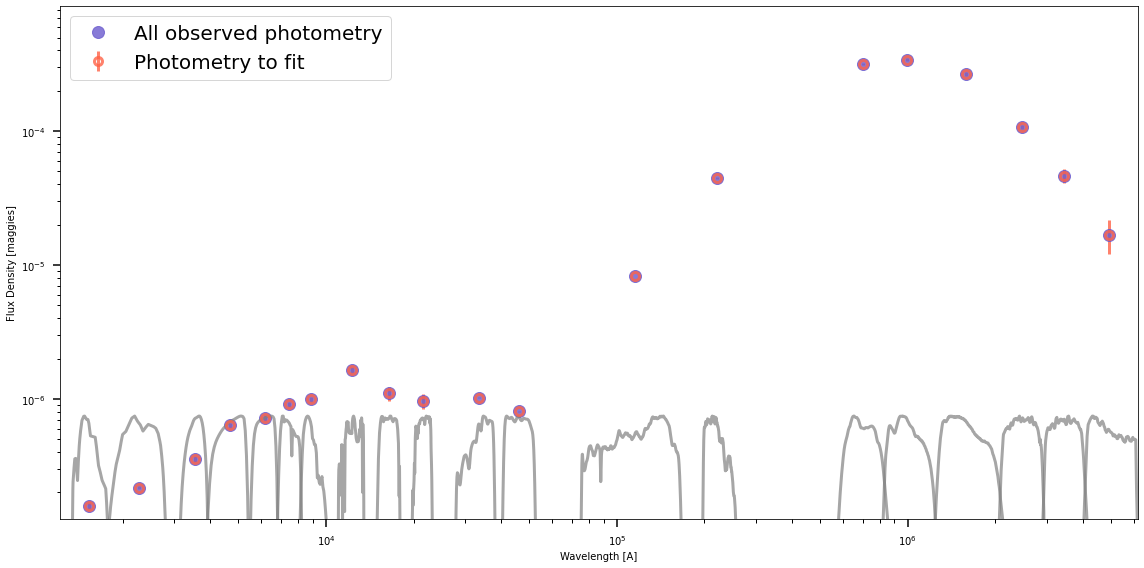

In [11]:
### Plot flux data ###
wphot = obs["phot_wave"]
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
ymin, ymax = obs["maggies"].min()*0.8, obs["maggies"].max()/0.4  
figure(figsize=(16,8))

### Plot all data ###
plot(wphot, obs['maggies'],
     label='All observed photometry',
     marker='o', markersize=12, alpha=0.8, ls='', lw=3,
     color='slateblue')

### overplot only data we want to fit (using phot_mask) ###
mask = obs["phot_mask"]
errorbar(wphot[mask], obs['maggies'][mask], 
         yerr=obs['maggies_unc'][mask], 
         label='Photometry to fit',
         marker='o', markersize=8, alpha=0.8, ls='', lw=3,
         ecolor='tomato', markerfacecolor='none', markeredgecolor='tomato', 
         markeredgewidth=3)

### Plot filters ###
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)


xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
xscale("log")
yscale("log")
legend(loc='best', fontsize=20)
tight_layout()


savefig(Galaxy_Path + 'G{0}_{1}_{2}_plot_data_1'.format(galaxy_num, Template_Type, ts))

In [12]:
from prospect.models.templates import TemplateLibrary
from prospect.models import priors
# TemplateLibrary.show_contents()       # Look at all the prepackaged parameter sets

# for i in range(0, len(Template_Type)):
#     print('Template: ', Template_Type[i])
#     TemplateLibrary.describe(Template_Type[i])  
#     print('\n\n')

In [13]:
run_params['agelims'] = [0.0,8.0,8.5,9.0,9.5,9.8,10.0]
agelims = run_params['agelims']
agelims[-1] = np.log10(tage_of_univ * 1e9)
agebins = np.array([agelims[:-1], agelims[1:]])
ncomp = agebins.shape[1]                                    #- 1 Had to modify for array sizes to fit

tilde_alpha = np.array([ncomp - i for i in list(range(1, ncomp))])

[[ 0.         8.         8.5        9.         9.5        9.8      ]
 [ 8.         8.5        9.         9.5        9.8       10.1216838]]
6
[5 4 3 2 1]
(2, 6)


In [14]:
### Build a prospect.models.SedModel object ###

def build_model(object_redshift = G_Redshift, tage_univ = tage_of_univ, 
    ldist = ldist_Mpc, TemplateType = Template_Type, ncomp = ncomp, agebins_init = agebins.T,        
    tilde_alpha = tilde_alpha, **extras):    

    ### Get (a copy of) the prepackaged model set dict (dict of dicts, keyed by parameter name) ###
    model_params = TemplateLibrary["alpha"]

    # From Leja's parameter files ----------------------------

    # model_params['add_igm_absorption']= {'N': 1, 'isfree': False, 'init': 1,
                    # 'units': None,
                    # 'prior_function': None,
                    # 'prior_args': None}

    # model_params['add_agb_dust_model'] = { 'N': 1, 'isfree': False, 'init': True,
                    # 'units': None,
                    # 'prior_function': None,
                    # 'prior_args': None}

    # model_params['pmetals'] = { 'N': 1, 'isfree': False, 'init': -99,
                    # 'units': '',
                    # 'prior_function': None,
                    # 'prior_args': {'mini':-3, 'maxi':-1}}

    model_params['agebins'] = { 'N': ncomp, 'isfree': False, 'init': agebins_init,
                    'units': 'log(yr)',
                    'prior': None}
    
    model_params['sfr_fraction'] = {'N': ncomp - 1, 'isfree': False, 
                    'init': np.zeros(ncomp - 1)+1./ncomp,
                    'depends_on': transform_zfraction_to_sfrfraction,
                    'units': '',
                    'prior': priors.TopHat(mini=np.full(ncomp - 1, 0.0), 
                        maxi=np.full(ncomp - 1, 1.0))}
    
    model_params['z_fraction'] = {'N': ncomp - 1, 'isfree': True, 
                    'init': np.array([(i-1)/float(i) for i in range(ncomp,1,-1)]),
                    'units': '',
                    'init_disp': 0.02,
                    'prior': priors.Beta(alpha=tilde_alpha, 
                        beta=np.ones_like(tilde_alpha),mini=0.0,maxi=1.0)}
                    # 'init': [0, 0]                                                 # OG
                    # 'prior': priors.Beta(alpha=1.0, beta=1.0, mini=0.0, maxi=1.0)  # OG
                    # 'init': np.array([(i-1)/float(i) for i in range(ncomp,1,-1)]), # Leja
    
    # model_params['imf_type'] = {'N': 1, 'isfree': False, 'init': 1, 
                    # 'units': None,
                    # 'prior_function_name': None,
                    # 'prior_args': None}
                    # #['init'] = 1  #chabrier

    # model_params['dust_type'] = {'N': 1, 'isfree': False, 'init': 4,
                    # 'units': 'index',
                    # 'prior_function_name': None,
                    # 'prior_args': None}

    # model_params['dust1'] = {'N': 1, 'isfree': False, 'depends_on': to_dust1,
                    # 'init': 1.0,
                    # 'units': '',
                    # 'prior': priors.TopHat(mini=0.0, maxi=6.0)}

    # model_params['dust1_fraction'] = {'N': 1, 'isfree': True, 'init': 1.0,
                    # 'init_disp': 0.8,
                    # 'disp_floor': 0.8,
                    # 'units': '',
                    # 'prior': priors.ClippedNormal(mini=0.0, maxi=2.0, mean=1.0, sigma=0.3)}

    # model_params['dust_index'] = {'N': 1, 'isfree': True, 'init': 0.0,
                    # 'init_disp': 0.25,
                    # 'disp_floor': 0.15,
                    # 'units': '',
                    # 'prior': priors.TopHat(mini=-2.2, maxi=0.4)}

    # model_params['dust1_index'] = {'N': 1, 'isfree': False, 'init': -1.0,
                    # 'units': '',
                    # 'prior': priors.TopHat(mini=-1.5, maxi=-0.5)}

    # model_params['dust_tesc'] = {'N': 1, 'isfree': False, 'init': 7.0,
                    # 'units': 'log(Gyr)',
                    # 'prior_function_name': None,
                    # 'prior_args': None }
    
    # model_params['add_dust_emission']= {'N': 1, 'isfree': False, 'init': 1,
                    # 'units': None,
                    # 'prior_function': None,
                    # 'prior_args': None}

    # model_params['duste_gamma'] = {'N': 1, 'isfree': True, 'init': 0.01,
                    # 'init_disp': 0.4,
                    # 'disp_floor': 0.3,
                    # 'units': None,
                    # 'prior': priors.TopHat(mini=0.0, maxi=1.0)}

    # model_params['duste_umin'] = {'N': 1, 'isfree': True, 'init': 1.0,
                    # 'init_disp': 10.0,
                    # 'disp_floor': 5.0,
                    # 'units': None,
                    # 'prior': priors.TopHat(mini=0.1, maxi=25.0)}

    # model_params['duste_qpah']= {'N': 1, 'isfree': True, 'init': 3.0,
                    # 'init_disp': 3.0,
                    # 'disp_floor': 3.0,
                    # 'units': 'percent',
                    # 'prior': priors.TopHat(mini=0.0, maxi=10.0)}

    # model_params['add_neb_emission'] = {'N': 1, 'isfree': False, 'init': True,
                    # 'units': r'log Z/Z_\odot',
                    # 'prior_function_name': None,
                    # 'prior_args': None}
    
    # model_params['add_neb_continuum']= {'N': 1, 'isfree': False, 'init': True,
                    # 'units': r'log Z/Z_\odot',
                    # 'prior_function_name': None,
                    # 'prior_args': None}

    # model_params['nebemlineinspec'] = {'N': 1, 'isfree': False, 'init': False,
                    # 'prior_function_name': None,
                    # 'prior_args': None}
    
    # model_params['gas_logz'] = {'N': 1, 'isfree': False, 'init': 0.0,
                    # 'depends_on': tie_gas_logz,
                    # 'units': r'log Z/Z_\odot',
                    # 'prior': priors.TopHat(mini=-2.0, maxi=0.5)}
    
    # model_params['gas_logu'] = {'N': 1, 'isfree': False, 'init': -2.0,
                    # 'units': '',
                    # 'prior': priors.TopHat(mini=-4.0, maxi=-1.0)}
    

    ######### AGN PARAMETERS ###############################################
    # model_params['add_agn_dust'] = {'N': 1, 'isfree': False, 'init': True,
    #                 'units': '',
    #                 'prior_function_name': None,
    #                 'prior_args': None}
    
    # model_params['fagn'] = {'N': 1, 'isfree': True, 'init': 0.05,
    #                 'init_disp': 0.05,
    #                 'disp_floor': 0.01,
    #                 'units': '',
    #                 'prior': priors.LogUniform(mini=0.000316228, maxi=3.0)}
    
    # model_params['agn_tau'] = {'N': 1, 'isfree': True, 'init': 10.0,
    #                 'init_disp': 10,
    #                 'disp_floor': 2,
    #                 'units': '',
    #                 'prior': priors.LogUniform(mini=5.0, maxi=150.0)}
    ########################################################################


    # ----------------------------------------------------------------
    # Unit Parameters (Leja)
    model_params['peraa'] = {'N': 1, 'isfree': False, 'init': False}
    model_params['mass_units'] = {'N': 1, 'isfree': False, 'init': 'mformed'}
    # ----------------------------------------------------------------

    # Original Parameters #

    model_params['logzsol'] =  { 'N': 1, 'isfree': True, 'init': -0.5,
                    'init_disp': 0.25,
                    'disp_floor': 0.2,
                    'units': r'$\log (Z/Z_\odot)$',
                    'prior': priors.TopHat(mini=-1.98, maxi=0.19)}

    model_params['sfh']['init'] = 4
    model_params["zred"]['init'] = object_redshift

    model_params["lumdist"] = {"N": 1, "isfree": False, "init": ldist, 
                    "units":"Mpc"} 

    model_params['logmass'] = {'N': 1, 'isfree': True, 'init': 10.0,
                    'units': 'Msun',
                    'prior': priors.TopHat(mini=5.0, maxi=13.0)}

    model_params['mass'] = { 'N': 1, 'isfree': False, 'init': 1e10, 
                    'units': 'Msun',
                    'depends_on' : transform_logmass_to_mass,
                    'prior': priors.TopHat(mini=1e5, maxi=1e13)}    
                    #priors.LogUniform(mini=1e8, maxi=1e12)         # OG
                    #['depends_on'] = transforms.zfrac_to_masses    # OG, diri
                    #["disp_floor"] = 1e8                           # OG

                    #['depends_on'] = transform_logmass_to_mass,    # Leja
                    #['isfree'] = False                             # Leja

    model_params['dust2'] = {'N': 1, 'isfree': True, 'init': 0.3,
                    'init_disp': 0.25,
                    'disp_floor': 0.15,
                    'units': '',
                    'prior': priors.TopHat(mini=0, maxi=4.0)}
                    #["init"] = 0.05                                # OGOG
                    #["prior"] = priors.TopHat(mini=1e-6, maxi=4.0) # OG


    # instantiate the model object using model_params specifications
    model = SedModel(model_params)

    return model

In [15]:
# # From Leja

# fit_order = ['logmass','z_fraction', 'dust2', 'logzsol']  # 'dust_index', 'dust1_fraction', 'duste_qpah', 'duste_gamma', 'duste_umin'

# tparams = [model_params[parnames.index(i)] for i in fit_order]
# for param in model_params: 
# if param['name'] not in fit_order:
# tparams.append(param)
# Added in AGN vars .
# only difference in codemodel_params = tparams


In [16]:
# run_params = {'verbose': False,
#                 'emcee' = True,
#                 'dynesty' = False,
#                 'optimize' = False,
#                 'optmization' = False,
#                 'nested_method' = "rwalk"
#                 'nlive_init' = 400,
#                 'nlive_batch' = 200,
#                 'nested_dlogz_init' = 0.05,
#                 'nested_posterior_thresh' = 0.05,
#                 'nested_maxcall' = int(1e7),
#                 'nmin' = 5,
#                 'min_method' = 'lm',
#                 # MCMC params
#                 'nwalkers': 128,        # Leja: 620, # Number of emcee walkers
#                 'nburn':[16, 32, 64],   # Leja: [150,200,200],
#                 'niter': 512,           # Leja: 7500, # Num iterations in MCMC sampling
#                 'interval': 0.2,
#                 # Convergence parameters
#                 # 'convergence_check_interval': 50,
#                 # 'convergence_chunks': 325,
#                 # 'convergence_kl_threshold': 0.016,
#                 # 'convergence_stable_points_criteria': 8, 
#                 # 'convergence_nhist': 50,
#                 # Model info
#                 'zcontinuous': 1,       # Leja: 2,
#                 'agelims': [0.0,8.0,8.5,9.0,9.5,9.8,10.0],
#                 'object_redshift': G_Redshift,
#                 'fixed_metallicity': None,
#                 'objname':'G{}'.format(galaxy_num),
#                 }

In [17]:
run_params = {}
run_params["ldist"] = ldist_Mpc     # luminosity distance to assume for translating M into m
run_params["object_redshift"] = G_Redshift
run_params["fixed_metallicity"] = None
run_params["add_duste"] = True


In [18]:
### Build model and view model ###
model = build_model(**run_params)
# print(model)
# print("\nInitial free parameter vector theta:\n  {}\n".format(model.theta))
# print("Initial parameter dictionary:\n{}".format(model.params))

In [19]:
def build_sps(zcontinuous=1, **extras):
    """
    :param zcontinuous: 
        A value of 1 insures that we use interpolation between SSPs to 
        have a continuous metallicity parameter (`logzsol`) (see python-FSPS)
    """
    # from prospect.sources import CSPSpecBasis
    # sps = CSPSpecBasis(zcontinuous=zcontinuous)
    # return sps

    # from prospect.sources.ssp_basis import FracSFH
    from prospect.sources.ssp_basis import FastStepBasis
    sps = FracSFH(zcontinuous = 1, **extras)         # run_params
    return sps

run_params["zcontinuous"] = 1

In [20]:
sps = build_sps(**run_params)
# help(sps.get_spectrum)

In [21]:
### View Model ###
### prediction for the data from any set of model params

### Generate the model SED at the initial value of theta ###
theta = model.theta.copy()
initial_spec, initial_phot, initial_mfrac = model.sed(theta, obs=obs, sps=sps)
title_text = ','.join(["{}={}".format(p, model.params[p][0]) 
                       for p in model.free_params])

a = 1.0 + model.params.get('zred', 0.0) # cosmological redshifting
wphot = obs["phot_wave"]    # photometric effective wavelengths
if obs["wavelength"] is None:
    # spectroscopic wavelengths
    # *restframe* spectral wavelengths, since obs["wavelength"] is None
    wspec = sps.wavelengths
    wspec *= a              # redshift them
else:
    wspec = obs["wavelength"]

xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
temp = np.interp(np.linspace(xmin,xmax,10000), wspec, initial_spec)
ymin, ymax = temp.min()*0.8, temp.max()/0.4
figure(figsize=(16,8))

# plot model + data
loglog(wspec, initial_spec, label='Model spectrum', 
       lw=0.7, color='navy', alpha=0.7)
errorbar(wphot, initial_phot, label='Model photometry', 
         marker='s',markersize=10, alpha=0.8, ls='', lw=3,
         markerfacecolor='none', markeredgecolor='blue', 
         markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry',
         marker='o', markersize=10, alpha=0.8, ls='', lw=3,
         ecolor='red', markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)
title(title_text)

# plot Filters
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()

savefig(Galaxy_Path + 'G{0}_{1}_{2}_SED_plot_2'.format(galaxy_num, Template_Type, ts))


In [22]:
### Likelyhood Function ###
"""
For nested sampling lnprobfn(theta, nested=True) will return the likelihood (since the prior probability is accounted for by drawing proposals from the priors), while for other types of MCMC sampling lnprobfn(theta, nested=False) returns the posterior probability.
"""

run_params["verbose"] = False

### Prospector has its own lnprobfn ###
# help(lnprobfn)

### Running Prospector ###
# Fit the model using chi squared minimization
# Ensemble MCMC sampler around best location from the minimization 
# Dynamic nested sampling with dynesty

# Here we will run all our building functions
obs = build_obs(**run_params)
sps = build_sps(**run_params)
model = build_model(**run_params)

# For fsps based sources it is useful to 
# know which stellar isochrone and spectral library
# print(sps.ssp.libraries)

# help(fit_model)

In [23]:
### Minimization ###
# Uses Levenberg-Marquardt, needed parameters in run_params
# requires a likelihood function that returns a vector of chi values
# imported lnprobfn function takes care of chi values to likelyhood

# --- start minimization ---- # 
run_params["dynesty"] = False
run_params["emcee"] = False
run_params["optimize"] = True
run_params["min_method"] = 'lm'
# Start minimization from nmin seperate places
# 1) based on current values of each param
# 2+) drawn from prior
# starting from extra draws = guard against local 
# mins or problems from starting at prior edge
run_params["nmin"] = 5 # initially 2, try 1

output = fit_model(obs, model, sps, lnprobfn=prospect.fitting.lnprobfn, **run_params)

print("Done optmization in {}s".format(output["optimization"][1]))

/mnt/c/Users/emma_d/ASTR_Research/lib/python3.8/site-packages/repo/prospector/prospect/models/priors.py:104: RuntimeWarning: divide by zero encountered in log
  lnp = np.log(p)
Done optmization in 207.52568435668945s


model.theta [-1.38397490e+00  3.50705881e+00  8.58305037e-01  9.79114390e-01
  9.93906708e-01  5.35874540e-01  5.55901964e-01  1.91538631e+09
  9.26369106e+00  5.58231958e+00  1.63436523e-03  1.75023310e-05
  1.05473691e+01  7.64574613e-01 -1.46950134e+00  1.03453920e+01]
ind_best =  4
theta_best =  [-1.38397490e+00  3.50705881e+00  8.58305037e-01  9.79114390e-01
  9.93906708e-01  5.35874540e-01  5.55901964e-01  1.91538631e+09
  9.26369106e+00  5.58231958e+00  1.63436523e-03  1.75023310e-05
  1.05473691e+01  7.64574613e-01 -1.46950134e+00  1.03453920e+01]


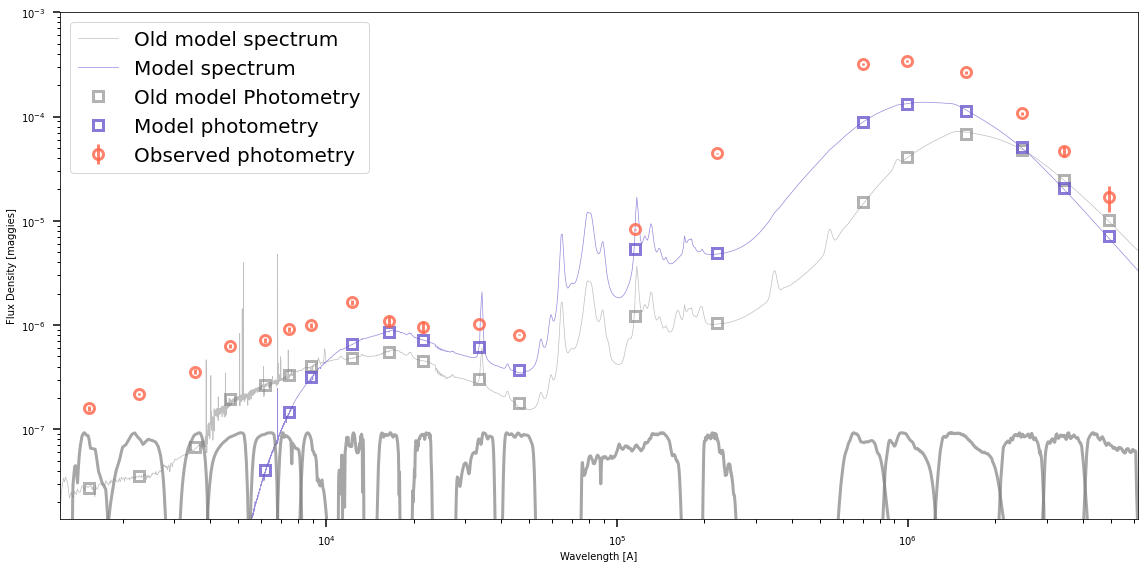

In [24]:
print("model.theta", model.theta)
(results, topt) = output["optimization"]
# Find which of the minimizations gave the best result, 
# and use the parameter vector for that minimization
ind_best = np.argmin([r.cost for r in results])
print("ind_best = ", ind_best)
theta_best = results[ind_best].x.copy()
print("theta_best = ", theta_best)

# Imodel_theta = model.theta          # added in
# Imodel_theta_best = theta_best      # added in

# generate model
prediction = model.mean_model(theta_best, obs=obs, sps=sps)
pspec, pphot, pfrac = prediction

figure(figsize=(16,8))

# wspec * (1 + model.params['zred'])

# plot Data, best fit model, and old models
loglog(wspec, initial_spec, label='Old model spectrum',
       lw=0.7, color='gray', alpha=0.5)
errorbar(wphot, initial_phot, label='Old model Photometry', 
         marker='s', markersize=10, alpha=0.6, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='gray', 
         markeredgewidth=3)
loglog(wspec, pspec, label='Model spectrum', 
       lw=0.7, color='slateblue', alpha=0.7) 
errorbar(wphot, pphot, label='Model photometry', 
         marker='s', markersize=10, alpha=0.8, ls='', lw=3,
         markerfacecolor='none', markeredgecolor='slateblue', 
         markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'],
         label='Observed photometry', 
         marker='o', markersize=10, alpha=0.8, ls='', lw=3, 
         ecolor='tomato', markerfacecolor='none', markeredgecolor='tomato', 
         markeredgewidth=3)

# plot filter transmission curves
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ymax = 10**-3
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()

savefig(Galaxy_Path + 'G{0}_{1}_{2}_min_model_plot_3'.format(galaxy_num, Template_Type, ts))

In [25]:
# False = no 2nd optimization before emcee sampling (optimization in dict = (None, 0.))
# True = 2nd optimization before sampling begins (optimization in dict = populated)
run_params["optimize"] = False
run_params["emcee"] = True
run_params["dynesty"] = False
# Number of emcee walkers
run_params["nwalkers"] = 128
# Number of iterations of the MCMC sampling
run_params["niter"] = 512
# Number of iterations in each round of burn-in
# After each round, the walkers are reinitialized based on the 
# locations of the highest probablity half of the walkers.
run_params["nburn"] = [16, 32, 64]

In [26]:
output = fit_model(obs, model, sps, lnprobfn=prospect.fitting.lnprobfn, **run_params)
print('done emcee in {0}s'.format(output["sampling"][1]))

/mnt/c/Users/emma_d/ASTR_Research/lib/python3.8/site-packages/repo/prospector/prospect/models/priors.py:104: RuntimeWarning: divide by zero encountered in log
  lnp = np.log(p)
done emcee in 4158.361411571503s


In [27]:
run_params["dynesty"] = False
run_params["optmization"] = False
run_params["emcee"] = True
run_params["nested_method"] = "rwalk"
run_params["nlive_init"] = 400
run_params["nlive_batch"] = 200
run_params["nested_dlogz_init"] = 0.05
run_params["nested_posterior_thresh"] = 0.05
run_params["nested_maxcall"] = int(1e7)

In [28]:
parser = prospect_args.get_parser()
# - Add custom arguments -
parser.add_argument('--add_duste', action="store_true",
                    help="If set, add dust emission to the model.")
parser.add_argument('--ldist', type=float, default=10,
                    help=("Luminosity distance in Mpc. Defaults to 10"
                          "(for case of absolute mags)"))
args, _ = parser.parse_known_args()
cli_run_params = vars(args)
# print(cli_run_params)

In [29]:
ts = time.strftime("%y%b%d", time.localtime())
hfile = 'G{0}_{1}_{2}_1mcmc.h5'.format(galaxy_num, Template_Type, ts)
obs, model, sps = build_obs(**run_params),  build_model(**run_params), build_sps(**run_params)# build_all(**run_params)

In [30]:
### Use to save results to disk ###
# hfile = "demo_emcee_mcmc.h5"
writer.write_hdf5(hfile, run_params, model, obs,
                  output["sampling"][0], output["optimization"][0],
                  tsample=output["sampling"][1],
                  toptimize=output["optimization"][1])

print('Finished')

Finished
/mnt/c/Users/emma_d/ASTR_Research/lib/python3.8/site-packages/repo/prospector/prospect/io/write_results.py:60: RuntimeWarning: Could not store paramfile text
  warnings.warn("Could not store paramfile text", RuntimeWarning)
/mnt/c/Users/emma_d/ASTR_Research/lib/python3.8/site-packages/repo/prospector/prospect/io/write_results.py:290: RuntimeWarning: Could not JSON serialize model_params, pickled instead
  warnings.warn("Could not JSON serialize {}, pickled instead".format(k),


In [32]:
import prospect.io.read_results as reader
results_type = "emcee" # | "dynesty"
# grab results (dictionary), the obs dictionary, and our corresponding models
# When using parameter files set `dangerous=True`
# result, obs, _ = reader.results_from("demo_{}_mcmc.h5".format(results_type), dangerous=False)   

# change to file that was just generated
result, obs, _ = reader.results_from('G{0}_{1}_{2}_mcmc.h5'.format(galaxy_num, Template_Type, ts), dangerous=False)


#The following commented lines reconstruct the model and sps object, 
# if a parameter file continaing the `build_*` methods was saved along with the results
# model = reader.get_model(result)
# sps = reader.get_sps(result)

# let's look at what's stored in the `result` dictionary
# print(result.keys())

In [33]:
# result

In [34]:
### Plotting Parameter Traces ###
if results_type == "emcee":
    chosen = np.random.choice(result["run_params"]["nwalkers"], size=10, replace=False)
    tracefig = reader.traceplot(result, figsize=(20,10), chains=chosen)
else:
    tracefig = reader.traceplot(result, figsize=(20,10))

savefig(Galaxy_Path + 'G{0}_{1}_{2}_param_trace_4'.format(galaxy_num, Template_Type, ts))

In [39]:
### Corner Plot ###
# maximum a posteriori (of the locations visited by the MCMC sampler)
imax = np.argmax(result['lnprobability'])
if results_type == "emcee":
    i, j = np.unravel_index(imax, result['lnprobability'].shape)
    theta_max = result['chain'][i, j, :].copy()
    thin = 5
else:
    theta_max = result["chain"][imax, :]
    thin = 1

# Fmodel_theta_best = theta_best  # added in
# Fmodel_theta_max = theta_max    # added in

print('Optimization value: {}'.format(theta_best))
print('MAP value: {}'.format(theta_max))
cornerfig = reader.subcorner(result, start=0, thin=thin, truths=theta_best, 
                             fig=subplots(16,16,figsize=(30,30))[0])       # MUST modify subplot(#,#)

savefig(Galaxy_Path + 'G{0}_{1}_{2}_corner_plot_5'.format(galaxy_num, Template_Type, ts))

Optimization value: [-1.38397490e+00  3.50705881e+00  8.58305037e-01  9.79114390e-01
  9.93906708e-01  5.35874540e-01  5.55901964e-01  1.91538631e+09
  9.26369106e+00  5.58231958e+00  1.63436523e-03  1.75023310e-05
  1.05473691e+01  7.64574613e-01 -1.46950134e+00  1.03453920e+01]
MAP value: [-9.27109600e-01  9.28682357e-01  9.18229838e-01  2.95561448e-01
  1.82331047e-01  1.58541530e-01  1.06442043e-01  1.91538631e+09
  7.47229645e+00  5.06770080e-01  9.54056468e-02  4.37149244e-03
  1.24602702e+01  1.41294804e+00  4.60864523e-01  1.02143812e+01]


In [40]:
# print(model.theta)
# print(theta_best)
# print(theta_max)

# print(Fmodel_theta_best)  #Theta best
# print(Fmodel_theta_max)   #Theta max
# print(Imodel_theta)
# print(Imodel_theta_best)

randint = np.random.randint
nwalkers, niter = run_params['nwalkers'], run_params['niter']
theta_theta = result['chain'][randint(nwalkers), randint(niter)]

# print(theta_theta)         #theta
print(result['bestfit'])


[-1.38397490e+00  3.50705881e+00  8.58305037e-01  9.79114390e-01
  9.93906708e-01  5.35874540e-01  5.55901964e-01  1.91538631e+09
  9.26369106e+00  5.58231958e+00  1.63436523e-03  1.75023310e-05
  1.05473691e+01  7.64574613e-01 -1.46950134e+00  1.03453920e+01]
[-9.27109600e-01  9.28682357e-01  9.18229838e-01  2.95561448e-01
  1.82331047e-01  1.58541530e-01  1.06442043e-01  1.91538631e+09
  7.47229645e+00  5.06770080e-01  9.54056468e-02  4.37149244e-03
  1.24602702e+01  1.41294804e+00  4.60864523e-01  1.02143812e+01]
[-1.38397490e+00  3.50705881e+00  8.58305037e-01  9.79114390e-01
  9.93906708e-01  5.35874540e-01  5.55901964e-01  1.91538631e+09
  9.26369106e+00  5.58231958e+00  1.63436523e-03  1.75023310e-05
  1.05473691e+01  7.64574613e-01 -1.46950134e+00  1.03453920e+01]
[-1.38397490e+00  3.50705881e+00  8.58305037e-01  9.79114390e-01
  9.93906708e-01  5.35874540e-01  5.55901964e-01  1.91538631e+09
  9.26369106e+00  5.58231958e+00  1.63436523e-03  1.75023310e-05
  1.05473691e+01  7.64

20 20


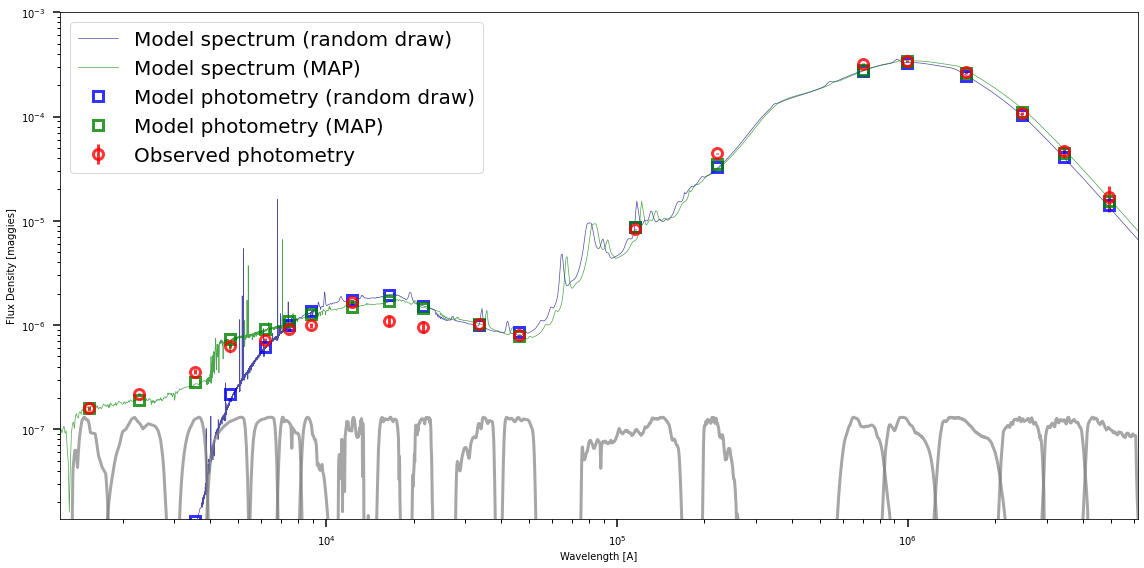

In [41]:
# https://github.com/bd-j/prospector/issues/186


# randomly chosen parameters from chain
randint = np.random.randint
if results_type == "emcee":
    nwalkers, niter = run_params['nwalkers'], run_params['niter']
    theta = result['chain'][randint(nwalkers), randint(niter)]
else:
    theta = result["chain"][randint(len(result["chain"]))]

# generate models
# sps = reader.get_sps(result)  # this works if using parameter files
mspec, mphot, mextra = model.mean_model(theta, obs, sps=sps)
mspec_map, mphot_map, _ = model.mean_model(theta_max, obs, sps=sps)

# Make plot of data and model
figure(figsize=(16,8))

print(len(mphot), len(wphot))

loglog(wspec, mspec, label='Model spectrum (random draw)',
       lw=0.7, color='navy', alpha=0.7)
loglog(wspec * (1 + model.params['zred']), mspec_map, label='Model spectrum (MAP)',
       lw=0.7, color='green', alpha=0.7)
errorbar(wphot, mphot, label='Model photometry (random draw)',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='blue', 
         markeredgewidth=3)
errorbar(wphot, mphot_map, label='Model photometry (MAP)',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='green', 
         markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry', ecolor='red', 
         marker='o', markersize=10, ls='', lw=3, alpha=0.8, 
         markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)

# plot transmission curves
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()

savefig(Galaxy_Path + 'G{0}_{1}_{2}_MAP_SED_6'.format(galaxy_num, Template_Type, ts))

In [42]:
end_time = time.time()
print("this program takes:", end_time - start_time, "seconds to run")
print("this program takes:", (end_time - start_time)/60, "minutes to run")

this program takes: 5025.034868717194 seconds to run
this program takes: 83.75058114528656 minutes to run
